In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: f'{x:.2f}')


# ML Libraries
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# ML Libraries
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope


# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


In [5]:
df = pd.read_csv('final_imputed.csv',index_col=0)#create_realistic_data()
print("=" * 80)

print(f"Dataset shape: {df.shape}")
print(f"Years available: {sorted(df['year'].unique())}")
print(f"Months per year:")
for year in sorted(df['year'].unique()):
    months = df[df['year'] == year]['month'].unique()
    print(f"  {year}: {len(months)} months ({', '.join(sorted(months))})")

Dataset shape: (33, 9)
Years available: [np.int64(2023), np.int64(2024), np.int64(2025)]
Months per year:
  2023: 10 months (Apr, Aug, Dec, Jul, Jun, Mar, May, Nov, Oct, Sept)
  2024: 12 months (Apr, Aug, Dec, Feb, Jan, Jul, Jun, Mar, May, Nov, Oct, Sept)
  2025: 11 months (Apr, Aug, Feb, Jan, Jul, Jun, Mar, May, Nov, Oct, Sept)


In [6]:

# Step 2: Feature Engineering - Create 10 features from the data
def create_engineered_features(data):
    """Create 10 engineered features from the base data"""
    df = data.copy()

    # Sort by year and month for proper rolling calculations
    df = df.sort_values(['year', 'month_num']).reset_index(drop=True)

    # 1. Total committed revenue
    df['total_committed'] = df['committed_unsig_revenue'] + df['committed_sign_revenue']

    # 2. Pipeline to committed ratio
    df['pipeline_to_committed_ratio'] = np.where(
        df['total_committed'] > 0,
        df['wtd_pipeline_revenue'] / df['total_committed'],
        0
    )

    # 3. Pipeline conversion efficiency (probability-adjusted)
    df['pipeline_conversion_efficiency'] = df['wtd_pipeline_revenue'] * df['avg_prob_pct'] / 100

    # 4. Signed vs unsigned ratio
    df['signed_unsigned_ratio'] = np.where(
        df['committed_unsig_revenue'] > 0,
        df['committed_sign_revenue'] / df['committed_unsig_revenue'],
        0
    )

    # 5. Revenue growth rate (MoM)
    df['revenue_growth_rate'] = df['actual_revenue'].pct_change().fillna(0).replace([np.inf, -np.inf], 0)

    # 6. Rolling 3-month average pipeline
    df['rolling_3m_pipeline'] = df['wtd_pipeline_revenue'].rolling(window=3, min_periods=1).mean()

    # 7. Rolling 6-month average committed
    df['rolling_6m_committed'] = df['total_committed'].rolling(window=6, min_periods=1).mean()

    # 8. Pipeline coverage (how many months of revenue is in pipeline)
    #    This feature needs 'actual_revenue' which will not be available for future simulated months.
    #    We will calculate it for historical data and then simulate it or handle separately.
    df['pipeline_coverage_months'] = np.where(
        df['actual_revenue'] > 0, # Only calculate where actual_revenue is known
        df['wtd_pipeline_revenue'] / df['actual_revenue'],
        0
    )

    # 9. Probability-weighted pipeline health
    df['pipeline_health_score'] = (df['wtd_pipeline_revenue'] * df['avg_prob_pct']) / 1000000

    # 10. Quarter-end indicator (Q1: Jan-Mar, Q2: Apr-Jun, Q3: Jul-Sep, Q4: Oct-Dec)
    df['quarter'] = ((df['month_num'] - 1) // 3) + 1

    # 11. Month-over-month pipeline growth
    df['pipeline_growth_rate'] = df['wtd_pipeline_revenue'].pct_change().fillna(0).replace([np.inf, -np.inf], 0)

    # 12. Committed growth rate
    df['committed_growth_rate'] = df['total_committed'].pct_change().fillna(0).replace([np.inf, -np.inf], 0)

    # Fill any NaN values that might have occurred (e.g., from pct_change at start)
    df = df.fillna(0)

    # Select the final 10 features for modeling
    feature_columns = [
        'wtd_pipeline_revenue',
        'total_committed',
        'pipeline_to_committed_ratio',
        'pipeline_conversion_efficiency',
        'signed_unsigned_ratio',
        'rolling_3m_pipeline',
        'rolling_6m_committed',
        'pipeline_coverage_months', # Will need careful simulation
        'pipeline_health_score',    # Will need careful simulation
        'pipeline_growth_rate'
    ]

    return df, feature_columns

# Create engineered features
df_with_features, feature_cols = create_engineered_features(df)
print("\n" + "=" * 80)
print("FEATURE ENGINEERING COMPLETED")
print("=" * 80)
print(f"Created {len(feature_cols)} engineered features:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2}. {col}")



FEATURE ENGINEERING COMPLETED
Created 10 engineered features:
 1. wtd_pipeline_revenue
 2. total_committed
 3. pipeline_to_committed_ratio
 4. pipeline_conversion_efficiency
 5. signed_unsigned_ratio
 6. rolling_3m_pipeline
 7. rolling_6m_committed
 8. pipeline_coverage_months
 9. pipeline_health_score
10. pipeline_growth_rate


In [ ]:


def create_advanced_features_fixing_underprediction(df):
    """
    Create  features
    """
    df_feat = df.copy()

    # ========== FOUNDATION: TIME AND BUSINESS CONTEXT ==========
    print("\n 2.1 TIME AND BUSINESS CONTEXT FOUNDATION")

    # Month index and remaining months (CRITICAL for normalization)
    df_feat['remaining_months'] = 13 - df_feat['month_num']
    df_feat['year_progress'] = (df_feat['month_num'] - 1) / 11  # 0 to 1 scale

    # Business quarter
    df_feat['quarter'] = ((df_feat['month_num'] - 1) // 3) + 1
    df_feat['quarter_progress'] = ((df_feat['month_num'] - 1) % 3) / 2

    # Business cycle position (based on revenue patterns)
    # Early (Jan-Mar), Middle (Apr-Aug), Late (Sep-Dec)
    df_feat['business_cycle'] = pd.cut(df_feat['month_num'],
                                       bins=[0, 3, 8, 13],
                                       labels=['early', 'middle', 'late'])

    # Convert to numerical
    cycle_map = {'early': 0, 'middle': 1, 'late': 2}
    df_feat['business_cycle_num'] = df_feat['business_cycle'].map(cycle_map)

    print(" Created time and business context features")

    # ========== CRITICAL FIX: SCALE-INVARIANT FEATURES ==========
    print("\n 2.2 SCALE-INVARIANT FEATURES (Fixes distribution shift)")


    forecast_cols = ['wtd_pipeline_revenue', 'committed_unsig_revenue', 'committed_sign_revenue']

    # 1. Monthly density (normalized by remaining months)
    for col in forecast_cols:
        df_feat[f'{col}_density'] = df_feat[col] / df_feat['remaining_months']
        # Handle potential infinite values
        df_feat[f'{col}_density'] = df_feat[f'{col}_density'].replace([np.inf, -np.inf], np.nan)

    # 2. Ratio features (scale invariant)
    df_feat['signed_to_total_ratio'] = (
        df_feat['committed_sign_revenue'] /
        (df_feat['committed_sign_revenue'] + df_feat['committed_unsig_revenue'] + 1e-10)
    )

    df_feat['pipeline_coverage'] = (
        df_feat['wtd_pipeline_revenue'] /
        (df_feat['committed_sign_revenue'] + df_feat['committed_unsig_revenue'] + 1e-10)
    )

    # 3. Percentage of annual target achieved (YTD perspective)
    df_feat['ytd_actual'] = df_feat.groupby('year')['actual_revenue'].cumsum()
    df_feat['ytd_percentage'] = df_feat['ytd_actual'] / (df_feat['ytd_actual'].max() + 1e-10)

    print("   Created scale-invariant features to handle distribution shift")

    # ========== NON-LINEAR TRANSFORMATIONS ==========
    print("\n 2.3 NON-LINEAR TRANSFORMATIONS (Captures complex relationships)")

    # issues: Linear models can't capture diminishing returns, exponential growth
    # Solution: Add polynomial and logarithmic transformations

    # Log transformations (for multiplicative effects)
    for col in [ 'committed_sign_revenue', 'wtd_pipeline_revenue']:
        df_feat[f'log_{col}'] = np.log1p(df_feat[col])
        df_feat[f'sqrt_{col}'] = np.sqrt(df_feat[col])

    # for col in ['actual_revenue', 'committed_sign_revenue', 'wtd_pipeline_revenue']:
    #     df_feat[f'log_{col}'] = np.log1p(df_feat[col])
    #     df_feat[f'sqrt_{col}'] = np.sqrt(df_feat[col])

    df_feat['log_actual_revenue_lag_1']=np.log1p(df_feat['actual_revenue'].shift(1))


    # Polynomial terms for key predictors
    for col in ['committed_sign_revenue', 'wtd_pipeline_revenue']:
        df_feat[f'{col}_squared'] = df_feat[col] ** 2
        df_feat[f'{col}_cubed'] = df_feat[col] ** 3
        df_feat[f'{col}_log_squared'] = np.log1p(df_feat[col]) ** 2

    # Reciprocal transformations (for diminishing returns)
    df_feat['inv_pipeline'] = 1 / (df_feat['wtd_pipeline_revenue'] + 1e-10)
    df_feat['inv_signed'] = 1 / (df_feat['committed_sign_revenue'] + 1e-10)


    print("   Added non-linear transformations")

    # ========== BUSINESS MOMENTUM METRICS ==========
    print("\n 2.4 BUSINESS MOMENTUM METRICS (Captures acceleration)")

    # REASONING: Underprediction often misses acceleration/deceleration
    # Solution: Add velocity and acceleration terms

    # Revenue momentum (1st derivative)
    df_feat['revenue_growth_1m'] = df_feat['actual_revenue'].pct_change(1)
    df_feat['revenue_growth_3m'] = df_feat['actual_revenue'].pct_change(3)
    df_feat['revenue_growth_12m'] = df_feat['actual_revenue'].pct_change(12)

    # Pipeline momentum
    df_feat['pipeline_growth_1m'] = df_feat['committed_sign_revenue'].pct_change(1)
    df_feat['pipeline_growth_3m'] = df_feat['committed_sign_revenue'].pct_change(3)

    # Acceleration (2nd derivative)
    df_feat['revenue_acceleration'] = df_feat['revenue_growth_1m'].diff(1)
    df_feat['pipeline_acceleration'] = df_feat['pipeline_growth_1m'].diff(1)

    # Momentum strength
    df_feat['momentum_strength'] = (
        df_feat['revenue_growth_3m'].abs() * df_feat['pipeline_growth_3m'].abs()
    )

    print("  Created business momentum metrics")

    # ========== INTERACTION FEATURES ==========
    print("\n 2.5 INTERACTION FEATURES (Captures combined effects)")

    # issues : Combined effect of multiple factors > sum of parts
    # Solution: Multiply key variables

    # 1. Pipeline pressure (size × time pressure)
    df_feat['pipeline_pressure'] = (
        df_feat['committed_sign_revenue_density'] *
        (12 - df_feat['month_num'])
    )

    # 2. Conversion urgency (signed ratio × time remaining)
    df_feat['conversion_urgency'] = (
        df_feat['signed_to_total_ratio'] *
        df_feat['remaining_months']
    )

    # 3. Business efficiency (revenue per pipeline)
    df_feat['business_efficiency'] = (
        df_feat['actual_revenue'] /
        (df_feat['wtd_pipeline_revenue'] + 1e-10)
    )

    # 4. Growth-pressure interaction
    df_feat['growth_pressure'] = (
        df_feat['revenue_growth_3m'] *
        df_feat['pipeline_pressure']
    )

    # 5. Seasonality-pressure interaction
    df_feat['seasonal_pressure'] = (
        np.sin(2 * np.pi * df_feat['month_num'] / 12) *
        df_feat['pipeline_pressure']
    )

    print("   Created interaction features")

    # ========== TEMPORAL FEATURES WITH GUIDELINES ==========
    print("\n 2.6 TEMPORAL FEATURES (Following guidelines)")

    # issues: Need to capture time dependencies without leakage
    # Solution: Use EMW and proper lag structures as per guidelines

    # 6-month EMW as per guidelines
    for col in ['actual_revenue', 'committed_sign_revenue', 'wtd_pipeline_revenue']:
        df_feat[f'{col}_ewm_6m'] = df_feat[col].ewm(span=6, min_periods=1).mean()
        df_feat[f'{col}_ewm_3m'] = df_feat[col].ewm(span=3, min_periods=1).mean()

    # Lag features with proper shifting (avoiding target leakage)
    lags = [1, 2, 3, 6, 12]
    for lag in lags:
        df_feat[f'revenue_lag_{lag}'] = df_feat['actual_revenue'].shift(lag)
        df_feat[f'pipeline_lag_{lag}'] = df_feat['committed_sign_revenue'].shift(lag)

    # Rolling statistics (using shift to avoid leakage)
    windows = [3, 6, 12]
    for window in windows:
        df_feat[f'revenue_rolling_mean_{window}'] = (
            df_feat['actual_revenue'].shift(1).rolling(window=window, min_periods=1).mean()
        )
        df_feat[f'revenue_rolling_std_{window}'] = (
            df_feat['actual_revenue'].shift(1).rolling(window=window, min_periods=1).std()
        )

    print("   Created temporal features following guidelines")

    # ========== BUSINESS INTELLIGENCE METRICS ==========
    print("\n 2.7 BUSINESS INTELLIGENCE METRICS (Domain knowledge)")

    # REASONING: Incorporate business rules and heuristics

    # 1. Run rate analysis
    df_feat['monthly_run_rate'] = df_feat['actual_revenue'].rolling(3).mean()
    df_feat['required_run_rate'] = (
        (df_feat['committed_sign_revenue'] + df_feat['committed_unsig_revenue']) /
        df_feat['remaining_months']
    )
    df_feat['run_rate_gap'] = df_feat['required_run_rate'] - df_feat['monthly_run_rate']
    df_feat['run_rate_gap_pct'] = df_feat['run_rate_gap'] / (df_feat['monthly_run_rate'] + 1e-10)

    # 2. Forecast confidence (using avg_prob_pct as guidance)
    df_feat['forecast_confidence'] = (
        df_feat['avg_prob_pct'] /
        df_feat['avg_prob_pct'].rolling(12, min_periods=1).mean()
    )

    # 3. Pipeline conversion efficiency
    df_feat['conversion_efficiency'] = (
        df_feat['actual_revenue'].shift(1) /
        (df_feat['wtd_pipeline_revenue'].shift(1) + 1e-10)
    ).rolling(6, min_periods=1).mean()

    # 4. Business health score (composite metric)
    df_feat['business_health'] = (
        0.4 * (df_feat['revenue_growth_3m'].clip(-0.5, 0.5) + 0.5) +  # Normalized to 0-1
        0.3 * df_feat['signed_to_total_ratio'] +
        0.2 * df_feat['forecast_confidence'].clip(0, 2) / 2 +
        0.1 * (1 - df_feat['run_rate_gap_pct'].clip(-1, 1).abs())
    )

    print("  Created business intelligence metrics")

    # ========== YEAR-OVER-YEAR FEATURES ==========
    print("\n 2.8 YEAR-OVER-YEAR FEATURES (Addresses distribution shift)")

    # issues: 2025 values different from 2023-2024
    # Solution: Compare with same period in previous years

    # YoY growth for key metrics
    for col in ['actual_revenue', 'committed_sign_revenue', 'wtd_pipeline_revenue']:
        df_feat[f'{col}_yoy'] = df_feat[col] / df_feat[col].shift(12)
        df_feat[f'{col}_yoy_growth'] = df_feat[f'{col}_yoy'] - 1

    # Same month comparison
    df_feat['same_month_last_year'] = df_feat.groupby('month_num')['actual_revenue'].shift(12)
    df_feat['same_month_growth'] = (
        df_feat['actual_revenue'] / df_feat['same_month_last_year'] - 1
    )

    # YTD comparison
    df_feat['ytd_last_year'] = df_feat.groupby('month_num')['ytd_actual'].shift(12)
    df_feat['ytd_growth'] = df_feat['ytd_actual'] / df_feat['ytd_last_year'] - 1

    print("  Created year-over-year features to normalize across years")

    # ========== COMPOUND AND DERIVED FEATURES ==========
    print("\n 2.9 COMPOUND AND DERIVED FEATURES (Higher-order insights)")

    # REASONING: Complex patterns require higher-order features

    # 1. Revenue predictability
    df_feat['revenue_predictability'] = 1 / (
        1 + df_feat['actual_revenue'].rolling(12).std() /
        df_feat['actual_revenue'].rolling(12).mean()
    )

    # 2. Forecast reliability index
    df_feat['forecast_reliability'] = (
        df_feat['committed_sign_revenue'].pct_change().abs().rolling(3).mean() *
        df_feat['forecast_confidence']
    )

    # 3. Business momentum index
    df_feat['business_momentum_index'] = (
        df_feat['revenue_growth_3m'].clip(0, 1) *
        df_feat['pipeline_growth_3m'].clip(0, 1) *
        df_feat['business_health']
    )

    # 4. Time-adjusted pipeline value
    df_feat['time_adjusted_pipeline'] = (
        df_feat['committed_sign_revenue'] *
        np.exp(-0.1 * (12 - df_feat['month_num']))  # Exponential decay
    )

    print("   Created compound features for higher-order insights")

    # ========== VALIDATION AND CLEANUP ==========
    print("\n 2.10 FEATURE VALIDATION AND CLEANUP")

    # Remove infinite values
    for col in df_feat.columns:
        if df_feat[col].dtype in [np.float64, np.int64]:
            df_feat[col] = df_feat[col].replace([np.inf, -np.inf], np.nan)

    # Count features created
    original_cols = set(df.columns)
    new_cols = set(df_feat.columns) - original_cols

    print(f"\n FEATURE ENGINEERING SUMMARY:")
    print(f"  Original features: {len(original_cols)}")
    print(f"  New features created: {len(new_cols)}")
    print(f"  Total features: {len(df_feat.columns)}")

    # Categorize features
    feature_categories = {
        'Time Context': [col for col in new_cols if any(x in col for x in ['month', 'quarter', 'cycle', 'progress'])],
        'Scale-Invariant': [col for col in new_cols if any(x in col for x in ['ratio', 'density', 'percentage', 'coverage'])],
        'Non-Linear': [col for col in new_cols if any(x in col for x in ['log_', 'sqrt_', '_squared', '_cubed', 'inv_'])],
        'Momentum': [col for col in new_cols if any(x in col for x in ['growth', 'acceleration', 'momentum'])],
        'Interactions': [col for col in new_cols if any(x in col for x in ['pressure', 'urgency', 'efficiency', 'interaction'])],
        'Temporal': [col for col in new_cols if any(x in col for x in ['lag_', 'ewm_', 'rolling_', 'shift'])],
        'Business Metrics': [col for col in new_cols if any(x in col for x in ['run_rate', 'confidence', 'health', 'predictability'])],
        'YoY Features': [col for col in new_cols if any(x in col for x in ['yoy', 'same_month', 'ytd_'])],
        'Compound': [col for col in new_cols if any(x in col for x in ['index', 'adjusted', 'reliability'])]
    }

    print("\n Feature Categories Created:")
    for category, features in feature_categories.items():
        if features:
            print(f"  {category}: {len(features)} features")

    # Sample important features
    print("\n SAMPLE OF KEY FEATURES CREATED:")
    key_features = [
        'committed_sign_revenue_density',  # Scale-invariant
        'signed_to_total_ratio',           # Ratio
        'log_committed_sign_revenue',      # Non-linear
        'revenue_growth_3m',               # Momentum
        'pipeline_pressure',               # Interaction
        'committed_sign_revenue_ewm_6m',   # Temporal (guideline)
        'run_rate_gap_pct',                # Business metric
        'committed_sign_revenue_yoy',      # YoY normalization
        'business_health',                 # Compound metric
        'time_adjusted_pipeline'           # Time-weighted
    ]

    for feat in key_features:
        if feat in df_feat.columns:
            print(f"  ✓ {feat}")

    return df_feat

# Create advanced features
print("\n Starting advanced feature engineering...")
df_features = create_advanced_features_fixing_underprediction(df)

print(" Advanced features created")

In [7]:

# Step 3: Prepare data for simulation
current_year = 2025
current_month = 3  # March 2025

# All historical data available for simulation (2023, 2024, 2025 Jan-March)
historical_data = df_with_features.copy()
print(f"\nHistorical data shape (all years): {historical_data.shape}")


Historical data shape (all years): (33, 21)


In [8]:
historical_data.columns

Index(['year', 'month', 'month_num', 'actual_revenue', 'wtd_pipeline_revenue',
       'committed_unsig_revenue', 'committed_sign_revenue', 'avg_prob_pct',
       'date', 'total_committed', 'pipeline_to_committed_ratio',
       'pipeline_conversion_efficiency', 'signed_unsigned_ratio',
       'revenue_growth_rate', 'rolling_3m_pipeline', 'rolling_6m_committed',
       'pipeline_coverage_months', 'pipeline_health_score', 'quarter',
       'pipeline_growth_rate', 'committed_growth_rate'],
      dtype='object')

In [11]:
# Step 4: Simulation of future months (apr-Dec 2025) using EWMA(6)
def simulate_future_months_emw6(historical_df, months_to_simulate, feature_columns,
                                target_month=3, target_year=2025):
    """
    Simulate features for future months using EWMA(6) on historical data
    Includes 2023, 2024, and 2025 Jan-May to simulate Jun-Dec 2025
    """
    # Get all data up to May 2025
    data_up_to_may = historical_df[
        (historical_df['year'] < target_year) |
        ((historical_df['year'] == target_year) & (historical_df['month_num'] <= target_month))
    ].copy()

    # Sort chronologically
    data_up_to_may = data_up_to_may.sort_values(['year', 'month_num']).reset_index(drop=True)

    simulated_months = []

    # For each month to simulate (June to December 2025)
    for i in range(1, months_to_simulate + 1):
        month_num = target_month + i
        year = target_year

        if month_num > 12:
            month_num = month_num - 12
            year = target_year + 1

        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                      'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
        month_name = month_names[month_num - 1]

        # Create base record for this month
        new_row = {
            'year': year,
            'month': month_name,
            'month_num': month_num,
        }

        # For each feature, calculate EWMA(6) using the last 6 available values
        for feature in feature_columns:
            # Get the last 6 values of this feature
            # For EWMA, only non-NaN values should be used from the combined data to avoid errors.
            feature_values = data_up_to_may[feature].dropna().tail(6).values

            if len(feature_values) == 0: # If no historical data for feature, default to 0 or mean of training data
                ewma_value = 0 # Or a more sophisticated default
            elif len(feature_values) < 6:
                ewma_value = np.mean(feature_values)
            else:
                # Calculate EWMA weights (alpha = 2/(N+1) where N=6)
                alpha = 2 / (6 + 1)
                weights = np.array([(1 - alpha) ** (5 - j) for j in range(6)])
                weights = weights / weights.sum()

                # Calculate EWMA
                ewma_value = np.sum(feature_values * weights)

            # Add small random variation (2% of value)
            variation = np.random.normal(0, ewma_value * 0.02)
            simulated_value = max(0, ewma_value + variation)

            # Apply seasonality adjustment based on month
            if month_num in [12, 1, 2]:  # Winter months
                simulated_value = simulated_value * 0.95
            elif month_num in [6, 7, 8]:  # Summer months
                simulated_value = simulated_value * 1.05

            new_row[feature] = simulated_value

        # Add to simulated months
        simulated_months.append(new_row)

        # Add this simulated month to data_up_to_may for next iteration's EWMA calculation
        # (so June simulation affects July, etc.)
        temp_df = pd.DataFrame([new_row])
        data_up_to_may = pd.concat([data_up_to_may, temp_df], ignore_index=True)

    simulated_df = pd.DataFrame(simulated_months)

    # Ensure all feature columns are present
    for col in feature_columns:
        if col not in simulated_df.columns:
            simulated_df[col] = 0 # Default for missing simulated features

    return simulated_df

# Simulate June to December 2025 (7 months)
months_to_simulate = 12 - current_month  # June(6) to December(12) = 7 months
simulated_future = simulate_future_months_emw6(
    historical_df=df_with_features, # Pass all historical data with engineered features
    months_to_simulate=months_to_simulate,
    feature_columns=feature_cols,
    target_month=current_month,
    target_year=current_year
)

print("\n" + "=" * 80)
print("FUTURE MONTHS SIMULATION COMPLETED")
print("=" * 80)
print(f"Simulated {months_to_simulate} Months :")
print(simulated_future[['year', 'month', 'month_num'] + feature_cols[:5]].to_string(index=False))



FUTURE MONTHS SIMULATION COMPLETED
Simulated 9 Months :
 year month  month_num  wtd_pipeline_revenue  total_committed  pipeline_to_committed_ratio  pipeline_conversion_efficiency  signed_unsigned_ratio
 2025   Apr          4          163120901.13    1305639447.38                         0.10                      1704561.12                   7.51
 2025   May          5          166644236.53    1382203535.43                         0.10                      1717574.22                   7.50
 2025   Jun          6          184679758.00    1499724705.47                         0.11                      1952026.58                   7.38
 2025   Jul          7          196789799.21    1601227078.87                         0.12                      2065639.59                   7.25
 2025   Aug          8          202451769.40    1521338514.30                         0.12                      2012959.63                   7.42
 2025  Sept          9          185756915.19    1506896095.83      

In [14]:

# Step 5: Combine actual May 2025 data with simulated future data for test set
# Get actual May 2025 data (features + temporal columns)
actual_may_2025_features = df_with_features[
    (df_with_features['year'] == current_year) &
    (df_with_features['month_num'] == current_month)
][feature_cols + ['year', 'month', 'month_num']].copy()

# Create test dataset with features (May actual features, Jun-Dec simulated features)
# This DataFrame will contain features and temporal info for May-Dec.
# 'actual_revenue' will NOT be in this df yet, but will be merged in.
test_data_features_combined = pd.concat([actual_may_2025_features, simulated_future[feature_cols + ['year', 'month', 'month_num']]],
                                        ignore_index=True)

# Get actual revenue for all relevant 2025 months (May-Nov from df_with_features)
test_actual_revenues_all = df_with_features[
    (df_with_features['year'] == current_year) &
    (df_with_features['month_num'] >= current_month)
][['year', 'month', 'month_num', 'actual_revenue']].copy()

# Merge the actual revenues into the test_data_features_combined DataFrame.
# This ensures test_data has a single 'actual_revenue' column correctly.
test_data = pd.merge(
    test_data_features_combined,
    test_actual_revenues_all,
    on=['year', 'month', 'month_num'],
    how='left'
)

print("\n" + "=" * 80)
print("TEST DATASET PREPARED")
print("=" * 80)
print(f"Test dataset includes: March 2025 (actual) + Jun-Dec 2025 (simulated)")
print(f"Test data shape: {test_data.shape}")


TEST DATASET PREPARED
Test dataset includes: March 2025 (actual) + Jun-Dec 2025 (simulated)
Test data shape: (10, 14)


In [13]:
test_data

,wtd_pipeline_revenue,total_committed,pipeline_to_committed_ratio,pipeline_conversion_efficiency,signed_unsigned_ratio,rolling_3m_pipeline,rolling_6m_committed,pipeline_coverage_months,pipeline_health_score,pipeline_growth_rate,year,month,month_num,actual_revenue
0,170640963.33,1506643048.37,0.11,3675166.22,6.03,230078531.36,1047384887.18,0.97,367.52,-0.24,2025,Mar,3,175925227.89
1,163120901.13,1305639447.38,0.10,1704561.12,7.51,141344275.35,853876943.96,0.96,165.97,7.03,2025,Apr,4,170681265.96
2,166644236.53,1382203535.43,0.10,1717574.22,7.50,145768503.71,836226608.34,1.01,174.87,7.35,2025,May,5,172455903.82
3,184679758.00,1499724705.47,0.11,1952026.58,7.38,155069530.01,907070411.66,1.11,193.11,8.84,2025,Jun,6,171322481.00
4,196789799.21,1601227078.87,0.12,2065639.59,7.25,168582249.38,916180446.33,1.16,201.19,8.94,2025,Jul,7,178908145.56
5,202451769.40,1521338514.30,0.12,2012959.63,7.42,175935391.82,949492068.11,1.13,202.67,7.53,2025,Aug,8,173445947.85
6,185756915.19,1506896095.83,0.11,2028243.90,7.62,169548111.69,881507733.47,1.10,201.62,7.67,2025,Sept,9,177238137.11
7,185399246.15,1498820234.74,0.12,2009511.20,7.29,164276848.85,892271610.13,1.09,203.23,7.99,2025,Oct,10,184324060.94
8,183753222.87,1537450219.89,0.12,2039690.56,7.18,164462272.00,922869729.75,1.09,201.68,8.11,2025,Nov,11,175457714.90
9,175193312.96,1446500769.98,0.10,1883694.34,6.93,154161939.85,893088329.01,1.01,189.82,7.67,2025,Dec,12,NaN


In [16]:
# Step 6: Prepare training data (2023 and 2024)
train_data = df_with_features[df_with_features['year'].isin([2023, 2024])].copy()

print(f"\nTraining data (2023-2024): {train_data.shape[0]} rows")
print(f"Test data (2025 May-Dec): {test_data.shape[0]} rows")

# Step 7: Scale the features
target_col = 'actual_revenue'

# Prepare feature matrices
X_train = train_data[feature_cols]
y_train = train_data[target_col]

X_test = test_data[feature_cols]
y_test = test_data[target_col]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n" + "=" * 80)
print("FEATURE SCALING COMPLETED")
print("=" * 80)
print(f"Training data scaled shape: {X_train_scaled.shape}")
print(f"Test data scaled shape: {X_test_scaled.shape}")



Training data (2023-2024): 22 rows
Test data (2025 May-Dec): 10 rows

FEATURE SCALING COMPLETED
Training data scaled shape: (22, 10)
Test data scaled shape: (10, 10)


In [17]:

# Step 8: Train Elastic Net model
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=10000)
elastic_net.fit(X_train_scaled, y_train)

print("\n" + "=" * 80)
print("ELASTIC NET MODEL TRAINED")
print("=" * 80)
print("Model Coefficients:")
for feature, coef in zip(feature_cols, elastic_net.coef_):
    print(f"  {feature:30}: {coef:12.4f}")
print(f"Intercept: {elastic_net.intercept_:.2f}")

# Step 9: Make predictions
y_pred = elastic_net.predict(X_test_scaled)

# Add predictions to test data
test_data['predicted_revenue'] = y_pred

print("\n" + "=" * 80)
print("PREDICTIONS COMPLETED")
print("=" * 80)



ELASTIC NET MODEL TRAINED
Model Coefficients:
  wtd_pipeline_revenue          :  602824.7845
  total_committed               : 9075423.4713
  pipeline_to_committed_ratio   : -3378743.3809
  pipeline_conversion_efficiency: 1595575.9066
  signed_unsigned_ratio         : 7311782.0161
  rolling_3m_pipeline           :  198285.2749
  rolling_6m_committed          : -630692.2985
  pipeline_coverage_months      : -5410996.4886
  pipeline_health_score         : 1595575.9287
  pipeline_growth_rate          :  256305.1175
Intercept: 146002236.25

PREDICTIONS COMPLETED


In [21]:

# Step 10: Create detailed comparison
comparison_df = test_data[['year', 'month', 'month_num',
                          'actual_revenue', 'predicted_revenue']].copy()

# Calculate differences
comparison_df['difference'] = comparison_df['actual_revenue'] - comparison_df['predicted_revenue']
comparison_df['error_pct'] = np.where(
    comparison_df['actual_revenue'] > 0,
    (comparison_df['difference'] / comparison_df['actual_revenue']) * 100,
    0
)
comparison_df['accuracy'] = (comparison_df['error_pct'])

print("\nDetailed Comparison (May 2025 onward):")
print("-" * 85)
print(f"{'Month':8} {'Year':6} {'Actual Revenue':>20} {'Predicted Revenue':>20} {'Difference':>15} {'Error':>10}")
print("-" * 85)

for _, row in comparison_df.iterrows():
    actual_str = f"${row['actual_revenue']:,.0f}" if not pd.isna(row['actual_revenue']) else "N/A"
    pred_str = f"${row['predicted_revenue']:,.0f}"
    diff_str = f"${row['difference']:,.0f}"
    acc_str = f"{row['accuracy']:.1f}%" if not pd.isna(row['accuracy']) else "N/A"

    print(f"{row['month']:8} {row['year']:6} {actual_str:>20} {pred_str:>20} {diff_str:>15} {acc_str:>10}")



Detailed Comparison (May 2025 onward):
-------------------------------------------------------------------------------------
Month    Year         Actual Revenue    Predicted Revenue      Difference      Error
-------------------------------------------------------------------------------------
Mar        2025         $175,925,228         $179,188,732     $-3,263,504      -1.9%
Apr        2025         $170,681,266         $165,040,922      $5,640,344       3.3%
May        2025         $172,455,904         $166,543,644      $5,912,260       3.4%
Jun        2025         $171,322,481         $168,615,034      $2,707,447       1.6%
Jul        2025         $178,908,146         $170,534,936      $8,373,210       4.7%
Aug        2025         $173,445,948         $169,187,640      $4,258,308       2.5%
Sept       2025         $177,238,137         $170,201,262      $7,036,875       4.0%
Oct        2025         $184,324,061         $169,087,102     $15,236,959       8.3%
Nov        2025        

In [24]:

# Step 11: Calculate performance metrics
def calculate_performance_metrics(y_true, y_pred):
    """Calculate comprehensive performance metrics"""
    # Filter out NaN values
    mask = ~np.isnan(y_true)
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

    if len(y_true_filtered) == 0:
        return {}

    metrics = {}

    # Basic metrics
    metrics['MAPE'] = mean_absolute_percentage_error(y_true_filtered, y_pred_filtered) * 100
    metrics['RMSE'] = np.sqrt(mean_squared_error(y_true_filtered, y_pred_filtered))
    metrics['R2'] = r2_score(y_true_filtered, y_pred_filtered)
    metrics['MAE'] = np.mean(np.abs(y_true_filtered - y_pred_filtered))
    metrics['MSE'] = mean_squared_error(y_true_filtered, y_pred_filtered)

    # Additional metrics
    metrics['Max Error'] = np.max(np.abs(y_true_filtered - y_pred_filtered))
    metrics['Mean Error'] = np.mean(y_pred_filtered - y_true_filtered)
    metrics['Std Error'] = np.std(y_pred_filtered - y_true_filtered)
    metrics['Median Absolute Error'] = np.median(np.abs(y_pred_filtered - y_true_filtered))

    # Directional accuracy
    if len(y_true_filtered) > 1:
        pred_dir = np.sign(np.diff(y_pred_filtered))
        true_dir = np.sign(np.diff(y_true_filtered))
        metrics['Directional Accuracy'] = np.mean(pred_dir == true_dir) * 100
    else:
        metrics['Directional Accuracy'] = 0

    # Cumulative metrics
    metrics['Cumulative Actual'] = np.sum(y_true_filtered)
    metrics['Cumulative Predicted'] = np.sum(y_pred_filtered)
    metrics['Cumulative Error %'] = ((metrics['Cumulative Predicted'] - metrics['Cumulative Actual']) /
                                     metrics['Cumulative Actual'] * 100)

    return metrics

metrics = calculate_performance_metrics(
    comparison_df['actual_revenue'].values,
    comparison_df['predicted_revenue'].values
)
metrics



{'MAPE': 3.670385172565651,
 'RMSE': np.float64(7395507.029769121),
 'R2': -2.3523847031903777,
 'MAE': np.float64(6506449.4648749465),
 'MSE': 54693524227364.48,
 'Max Error': np.float64(15236959.095013559),
 'Mean Error': np.float64(-5781226.250307907),
 'Std Error': np.float64(4612043.719449682),
 'Median Absolute Error': np.float64(5912259.980246007),
 'Directional Accuracy': np.float64(62.5),
 'Cumulative Actual': np.float64(1579758885.0356357),
 'Cumulative Predicted': np.float64(1527727848.7828646),
 'Cumulative Error %': np.float64(-3.293606179122546)}

In [23]:

# Step 13: Feature Importance Analysis
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': elastic_net.coef_,
    'Absolute Coefficient': np.abs(elastic_net.coef_)
})
feature_importance['Importance %'] = (
    feature_importance['Absolute Coefficient'] /
    feature_importance['Absolute Coefficient'].sum() * 100
)
feature_importance = feature_importance.sort_values('Importance %', ascending=False)

print("\n" + "=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)
print("Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))



FEATURE IMPORTANCE ANALYSIS
Top 10 Most Important Features:
                       Feature  Coefficient  Absolute Coefficient  Importance %
               total_committed   9075423.47            9075423.47         30.19
         signed_unsigned_ratio   7311782.02            7311782.02         24.33
      pipeline_coverage_months  -5410996.49            5410996.49         18.00
   pipeline_to_committed_ratio  -3378743.38            3378743.38         11.24
         pipeline_health_score   1595575.93            1595575.93          5.31
pipeline_conversion_efficiency   1595575.91            1595575.91          5.31
          rolling_6m_committed   -630692.30             630692.30          2.10
          wtd_pipeline_revenue    602824.78             602824.78          2.01
          pipeline_growth_rate    256305.12             256305.12          0.85
           rolling_3m_pipeline    198285.27             198285.27          0.66


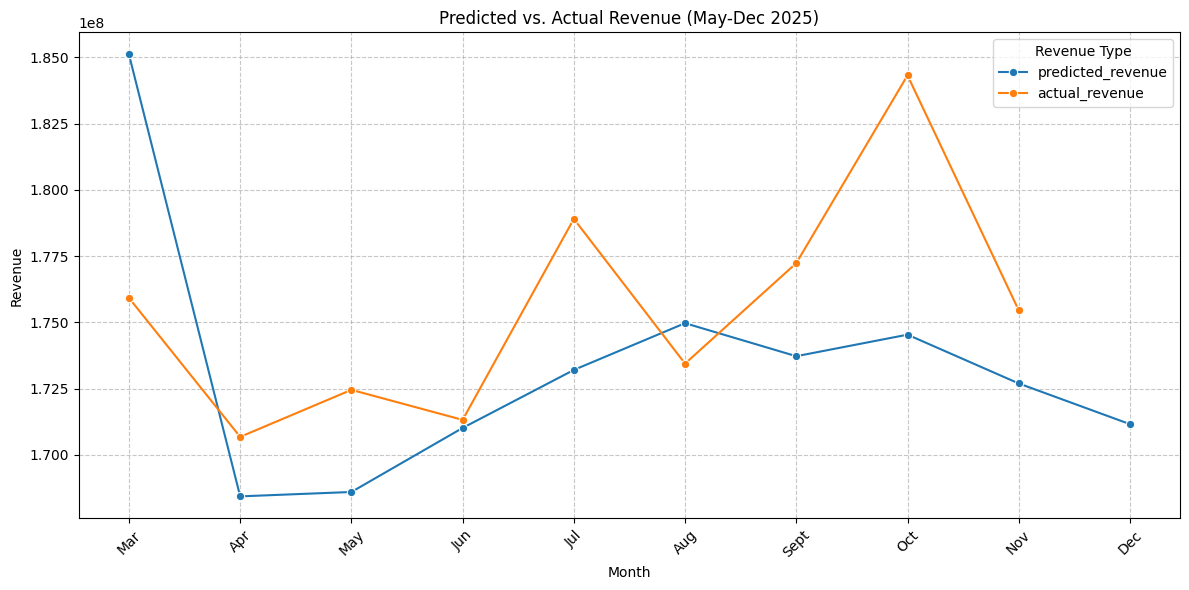

In [38]:

# Prepare data for plotting
plot_df = comparison_df[['month', 'predicted_revenue', 'actual_revenue']].set_index('month')

# Melt the DataFrame for easier plotting with seaborn
plot_df_melted = plot_df.reset_index().melt(id_vars=['month'],
                                            var_name='Revenue Type',
                                            value_name='Revenue')

# Ensure the months are in chronological order for plotting
month_order = ['Mar','Apr','May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
plot_df_melted['month'] = pd.Categorical(plot_df_melted['month'], categories=month_order, ordered=True)
plot_df_melted = plot_df_melted.sort_values('month')

plt.figure(figsize=(12, 6))
sns.lineplot(data=plot_df_melted, x='month', y='Revenue', hue='Revenue Type', marker='o')
plt.title('Predicted vs. Actual Revenue (May-Dec 2025)')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()